In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
'''
实测，不加上面这一行内核会崩溃 deepseek说一般在Mac上需要这一行，我测试的环境是Windows
另外，文件名如果是`code.ipynb`，内核会崩溃，改成`solution.ipynb`后正常了
'''

import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [2]:
class Net(torch.nn.Module):
    def __init__(self):
        '''先调用父类的__init__函数，然后定义了四个全连接层'''
        super().__init__()
        self.fc1 = torch.nn.Linear(28*28, 64)
        self.fc2 = torch.nn.Linear(64, 64)
        self.fc3 = torch.nn.Linear(64, 64)
        self.fc4 = torch.nn.Linear(64, 10)
    def forward(self, x):
        x = torch.nn.functional.relu(self.fc1(x))
        x = torch.nn.functional.relu(self.fc2(x))
        x = torch.nn.functional.relu(self.fc3(x))
        x = torch.nn.functional.log_softmax(self.fc4(x), dim=1)
        return x

In [3]:
def get_data_loader(is_train):
    to_tensor = transforms.Compose([transforms.ToTensor()])
    data_set = datasets.MNIST("", is_train, transform=to_tensor,download=True)
    return DataLoader(data_set, batch_size=15, shuffle=True)

In [4]:
def evaluate(test_data, net):
    n_corret = 0
    n_total = 0
    with torch.no_grad():
        for (x, y) in test_data:
            outputs = net.forward(x.view(-1,28*28))
            for i, output in enumerate(outputs):
                if torch.argmax(output) == y[i]:
                    n_corret += 1
                n_total += 1
    return n_corret / n_total

In [5]:
def main():
    train_data = get_data_loader(is_train = True)
    test_data = get_data_loader(is_train = True)
    net = Net()
    print("initial accuracy:", evaluate(test_data,net))
    optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
    for epoch in range(2):
        for (x, y) in train_data:
            net.zero_grad()
            output = net.forward(x.view(-1,28*28))
            loss = torch.nn.functional.nll_loss(output, y)
            loss.backward()
            optimizer.step()
        print("epoch", epoch, "accuracy:", evaluate(test_data,net))
    for(n, (x, _)) in enumerate(test_data):
        if (n > 3):
            break
        predict = torch.argmax(net.forward(x[0].view(-1, 28*28)))
        plt.figure(n)
        plt.imshow(x[0].view(28,28))
        plt.title("prediction: " + str(int(predict)))
    plt.show()

initial accuracy: 0.09938333333333334
epoch 0 accuracy: 0.9617166666666667
epoch 1 accuracy: 0.9750333333333333


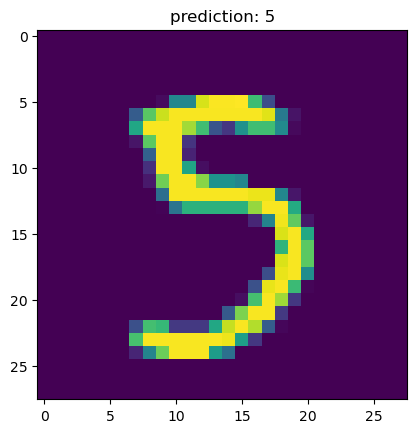

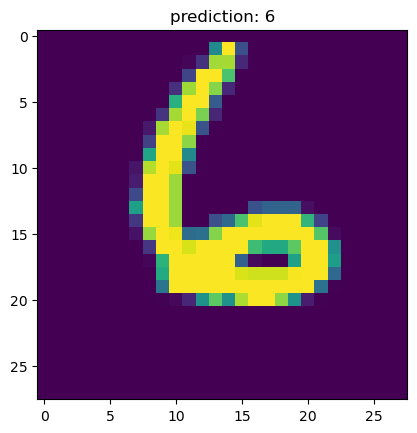

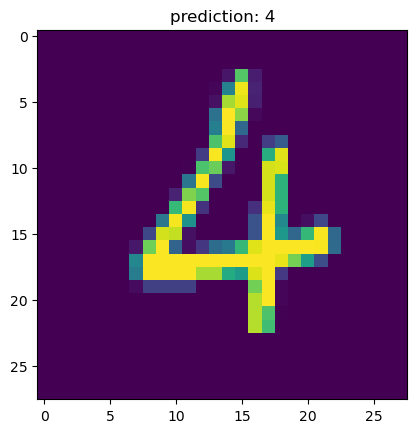

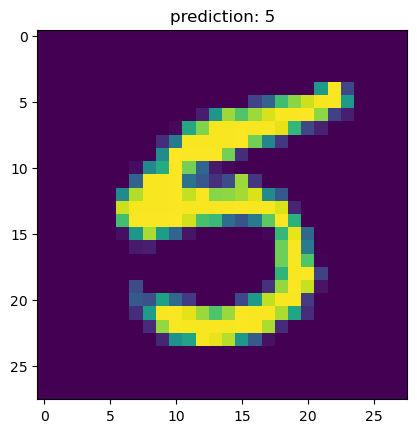

In [6]:
if __name__ == "__main__":
    main()